## With this homework, I practiced building multiple models on the command-line
#### - (1) Use multi-omics data from human cancer cell lines from the CCLE and GDSC databases. 
#### - (2) Build the models on the CCLE dataset and evaluate the models on the GDSC dataset. 
#### - (3) Benchmarking of different deep learning architectures and different combinations of omic data modalities used as input.
#### - (4) This jupyter notebook explores the best performing models. 

In [1]:
import os
import glob
import flexynesis
import torch
import numpy as np
import seaborn as sns
import pandas as pd
import math
import random
import lightning as pl
from flexynesis import plot_dim_reduced
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from IPython.display import display

Seed set to 42


#### Download and unpack the data: https://bimsbstatic.mdc-berlin.de/akalin/buyar/flexynesis-benchmark-datasets/ccle_vs_gdsc.tgz

In [2]:
if not os.path.exists("ccle_vs_gdsc"):
    !wget -O ccle_vs_gdsc.tgz "https://bimsbstatic.mdc-berlin.de/akalin/buyar/flexynesis-benchmark-datasets/ccle_vs_gdsc.tgz" && tar -xzvf ccle_vs_gdsc.tgz

### Use flexynesis on the command-line to predict drug responses for “Erlotinib”. Write a bash script to run the following experiments: Try a combination of:

a) different architectures: e.g. DirectPred, Supervised VAE, GNN (Test at least 2 of these).

b) data type combinations (e.g. mutation, mutation + rna, mutation + cnv) (Test at least 2 of these)

c) fusion methods: early, intermediate (applies only to tools other than GNN)

So, in total, you will run maximally 3 x 3 x 2 = 18 different flexynesis runs (and minimally 2 x 2 x 2 = 8 different runs).

Note: GNNs actually only support "early" fusion, so you can skip "intermediate" fusion for GNNs, but you can try different graph convolution options for GNNs. For GNNs, try "GC" and "SAGE" as different options in your experiment (See --gnn_conv_type argument).

Hint 1: Restrict your analysis to 5-10% of the features (use a combination of variance and laplacian score filtering).

Hint 2: It is okay to use few HPO iterations for this exercise (e.g. 15 iterations or so) (considering the resourse/time limits etc). The point of this exercise is not to find the perfect model, but to get an insight on the idea of benchmarking different setups.


In [3]:
data_importer = flexynesis.DataImporter(path ='ccle_vs_gdsc', 
                                        data_types = ['mutation', 'rna', 'cnv'], log_transform=False, 
                                        concatenate=False, top_percentile=10, min_features=1000,
                                       variance_threshold=0.5)
train_dataset, test_dataset = data_importer.import_data()


[INFO] ================= Importing Data =================
[INFO] Validating data folders...

[INFO] ----------------- Reading Data ----------------- 
[INFO] Importing ccle_vs_gdsc/train/mutation.csv...
[INFO] Importing ccle_vs_gdsc/train/clin.csv...
[INFO] Importing ccle_vs_gdsc/train/cnv.csv...
[INFO] Importing ccle_vs_gdsc/train/rna.csv...

[INFO] ----------------- Reading Data ----------------- 
[INFO] Importing ccle_vs_gdsc/test/mutation.csv...
[INFO] Importing ccle_vs_gdsc/test/clin.csv...
[INFO] Importing ccle_vs_gdsc/test/cnv.csv...
[INFO] Importing ccle_vs_gdsc/test/rna.csv...

[INFO] ----------------- Checking for problems with the input data ----------------- 

[WARNING] Warnings:

[WARNING] 1. Warning: Some sample labels in train/clin.csv are missing in train/cnv.csv: {'KP-1NL', 'IOMM-Lee', 'MKN45', 'DOV13', 'EW-8', 'UACC-62', 'HCC2108', 'TE 617.T', 'HCC2814', 'YD-8', 'HT115', 'OV56', 'NCI-H211', 'NCI-H684', 'ESS-1', 'SaOS-2', 'LN-443', 'LK-2', 'LN-428', 'TE-1', 'HCC1833', 

Filtering redundant features: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3395.59it/s]


[INFO] Implementing feature selection using laplacian score for layer: cnv with  11304 features  and  935  samples 


Filtering redundant features: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1130/1130 [00:00<00:00, 45548.20it/s]



[INFO] ----------------- Processing Data (test) ----------------- 

[INFO] ----------------- Cleaning Up Data ----------------- 

[INFO] working on layer:  mutation
[INFO] Imputing NA values to median of features, affected # of cells in the matrix 1  # of rows: 1
[INFO] Number of NA values:  0
[INFO] DataFrame mutation - Removed 41 features.

[INFO] working on layer:  rna
[INFO] Number of NA values:  0
[INFO] DataFrame rna - Removed 5824 features.

[INFO] working on layer:  cnv
[INFO] Imputing NA values to median of features, affected # of cells in the matrix 19540  # of rows: 329
[INFO] Number of NA values:  0
[INFO] DataFrame cnv - Removed 11634 features.
[INFO] DataFrame mutation - Removed 61 samples (8.63%).
[INFO] DataFrame rna - Removed 53 samples (7.29%).
[INFO] DataFrame cnv - Removed 56 samples (5.79%).

[INFO] ----------------- Harmonizing Data Sets ----------------- 

[INFO] ----------------- Finished Harmonizing ----------------- 

[INFO] ----------------- Normalizing Data

### Exploratory Data Analysis 

In [4]:
train_dataset.dat, test_dataset.dat

({'rna': tensor([[-0.0208, -0.3414, -0.4249,  ..., -0.2060, -0.3766,  0.6584],
          [-0.3612, -0.2744, -0.4973,  ..., -0.1911, -0.1769, -0.6552],
          [-0.3049, -0.2824, -0.3996,  ..., -0.3177, -0.2875, -0.6266],
          ...,
          [-0.1632, -0.3509, -0.4916,  ..., -0.2083, -0.0203, -0.6274],
          [-0.1413, -0.3829, -0.4328,  ..., -0.5116, -0.2376, -0.4091],
          [-0.3027, -0.2340, -0.4338,  ..., -0.2162,  0.1707, -0.4789]]),
  'cnv': tensor([[ 0.7062,  0.3192,  0.7958,  ..., -0.7854,  0.0438, -0.7831],
          [-0.8651, -0.8125, -0.8801,  ..., -0.5187, -0.8108, -0.5191],
          [ 0.1955,  0.0308,  0.3297,  ..., -1.7013,  0.1330, -1.6903],
          ...,
          [-0.4542, -0.5713, -0.4280,  ..., -0.1911, -0.3265, -0.1945],
          [ 0.0040,  0.9154,  0.0940,  ...,  0.6679,  0.9288,  0.6562],
          [ 0.7815, -0.4772, -1.1490,  ..., -0.4251, -2.4611, -0.4263]]),
  'mutation': tensor([[-0.4054, -0.3480, -0.2249,  ..., -0.3142, -0.1623,  0.7577],
    

In [5]:
train_dataset.dat['mutation'].shape, train_dataset.dat['cnv'].shape, train_dataset.dat['rna'].shape

(torch.Size([935, 24]), torch.Size([935, 989]), torch.Size([935, 689]))

In [6]:
test_dataset.dat['mutation'].shape, test_dataset.dat['cnv'].shape, test_dataset.dat['rna'].shape

(torch.Size([560, 24]), torch.Size([560, 989]), torch.Size([560, 689]))

In [7]:
train_dataset.samples[1:20], train_dataset.features

(['COLO 704',
  'Hs 274.T',
  'B-CPAP',
  'NCI-H2452',
  'NCO2',
  'Hs 821.T',
  'RKN',
  'TEN',
  'DMS 153',
  'NCI-H596',
  'SW620',
  'EFM-19',
  'NCI-H1666',
  'KYM-1',
  'MKN74',
  'NCI-H3255',
  'HCC1395',
  'Ishikawa (Heraklio) 02 ER-',
  'JHUEM-3'],
 {'rna': Index(['SOX10', 'TNFRSF17', 'CD53', 'TCL1A', 'CD19', 'VPREB3', 'MLANA',
         'LGALS4', 'YAP1', 'BTK',
         ...
         'S100B', 'IKZF1', 'TYR', 'RAB25', 'PMEL', 'SLC45A2', 'SCG3', 'AZU1',
         'RAG1', 'HLA-DRA'],
        dtype='object', length=689),
  'cnv': Index(['GNAS-AS1', 'SNORA22', 'LINC01260', 'LUZP6', 'POLR2J2', 'HCK', 'NUPL2',
         'KIAA0586', 'RNASEH2C', 'ANKRD9',
         ...
         'PRSS58', 'GCH1', 'MIR4308', 'PLD4', 'AHNAK2', 'SUGCT', 'GPR68',
         'ITPK1', 'ZNHIT1', 'CCDC88C'],
        dtype='object', length=989),
  'mutation': Index(['APC', 'BRAF', 'CDH1', 'CDKN2A', 'CTNNB1', 'EGFR', 'FBXW7', 'KDM6A',
         'KRAS', 'MAP2K4', 'MLH1', 'MSH2', 'NF1', 'NF2', 'NOTCH1', 'NRAS',
         '

In [8]:
test_dataset.samples[1:20], test_dataset.features

(['B-CPAP',
  'NCI-H2452',
  'NCI-H596',
  'SW620',
  'EFM-19',
  'NCI-H1666',
  'OMC-1 [Human cervical carcinoma]',
  'HCC1395',
  'Lu-134-A',
  'ESS-1',
  'RCM-1 [Human rectum adenocarcinoma]',
  'NCI-H2052',
  'BB49-HNC',
  'UACC-257',
  'D-263MG',
  'NALM-6',
  'MZ-MEL-2',
  'AM-38',
  'OVCAR-8'],
 {'rna': Index(['SOX10', 'TNFRSF17', 'CD53', 'TCL1A', 'CD19', 'VPREB3', 'MLANA',
         'LGALS4', 'YAP1', 'BTK',
         ...
         'S100B', 'IKZF1', 'TYR', 'RAB25', 'PMEL', 'SLC45A2', 'SCG3', 'AZU1',
         'RAG1', 'HLA-DRA'],
        dtype='object', length=689),
  'cnv': Index(['GNAS-AS1', 'SNORA22', 'LINC01260', 'LUZP6', 'POLR2J2', 'HCK', 'NUPL2',
         'KIAA0586', 'RNASEH2C', 'ANKRD9',
         ...
         'PRSS58', 'GCH1', 'MIR4308', 'PLD4', 'AHNAK2', 'SUGCT', 'GPR68',
         'ITPK1', 'ZNHIT1', 'CCDC88C'],
        dtype='object', length=989),
  'mutation': Index(['APC', 'BRAF', 'CDH1', 'CDKN2A', 'CTNNB1', 'EGFR', 'FBXW7', 'KDM6A',
         'KRAS', 'MAP2K4', 'MLH1', 'MSH2

In [9]:
train_dataset.ann

{'Crizotinib': tensor([       nan,        nan,        nan, 2.4927e-02, 1.5810e-02, 3.1539e-01,
                nan, 1.5027e-02, 0.0000e+00,        nan,        nan, 1.0264e-01,
         4.3664e-02, 2.0824e-02, 4.1460e-02, 0.0000e+00, 1.1192e-01, 0.0000e+00,
         1.5148e-02,        nan,        nan, 5.8767e-02,        nan, 7.2986e-03,
                nan,        nan, 0.0000e+00,        nan, 0.0000e+00,        nan,
         4.6343e-03,        nan,        nan, 5.2503e-02,        nan,        nan,
         2.6602e-02,        nan,        nan,        nan,        nan,        nan,
                nan,        nan, 3.4074e-02, 6.6740e-02, 2.6957e-01,        nan,
         1.2539e-01, 9.5140e-02,        nan, 1.4447e-02,        nan,        nan,
                nan,        nan, 1.3735e-02,        nan,        nan,        nan,
         1.0407e-01, 0.0000e+00, 2.0031e-02,        nan,        nan, 0.0000e+00,
                nan, 0.0000e+00, 1.9905e-02,        nan, 3.5230e-02,        nan,
         3.879

In [10]:
flexynesis.print_summary_stats(train_dataset)

Summary for variable: Crizotinib
Numerical Variable Summary: Median = 0.0348820359866738, Mean = 0.05367918925271896
------
Summary for variable: Dovitinib
Numerical Variable Summary: Median = 0.0747548468378515, Mean = 0.08868079986988005
------
Summary for variable: Erlotinib
Numerical Variable Summary: Median = 0.0401425137728223, Mean = 0.06560994516154504
------
Summary for variable: Irinotecan
Numerical Variable Summary: Median = 0.3920620379485415, Mean = 0.38968231036548984
------
Summary for variable: L-685458
Numerical Variable Summary: Median = 0.0144951759575499, Mean = 0.030708233328112813
------
Summary for variable: Lapatinib
Numerical Variable Summary: Median = 0.0390705370047462, Mean = 0.06683012778667083
------
Summary for variable: LBW242
Numerical Variable Summary: Median = 0.0547794573417837, Mean = 0.07822785863411183
------
Summary for variable: Nilotinib
Numerical Variable Summary: Median = 0.0296334712782784, Mean = 0.0512712547926707
------
Summary for variab

In [11]:
flexynesis.print_summary_stats(test_dataset)

Summary for variable: (2R,6aS,12aS)-2-Isopropyl-8,9-dimethoxy-1,2,12,12a-tetrahydrochromeno[3,4-b]furo[2,3-h]chromen-6(6aH)-one
Numerical Variable Summary: Median = 0.137673879066792, Mean = 0.15921163001570104
------
Summary for variable: (5R,5aR,8aR)-9-Bromo-5-(3,4,5-trimethoxyphenyl)-5,8,8a,9-tetrahydrofuro[3',4':6,7]naphtho[2,3-d][1,3]dioxol-6(5aH)-one
Numerical Variable Summary: Median = 0.192777551603734, Mean = 0.19435297125740514
------
Summary for variable: 1,3-Bis(2-chloroethyl)-1-nitrosourea
Numerical Variable Summary: Median = 0.0082343323580145, Mean = 0.02037577440306922
------
Summary for variable: 2-fluoroAraA (fludarabine)
Numerical Variable Summary: Median = 0.0321679832898623, Mean = 0.07052042918700793
------
Summary for variable: 2-Pyridinecarboxylic acid
Numerical Variable Summary: Median = 0.03230051266080725, Mean = 0.03717847227732785
------
Summary for variable: 2H-Indol-2-one, 3,3-bis[4-(acetyloxy)phenyl]-1,3-dihydro-
Numerical Variable Summary: Median = 0.03

In [12]:
train_dataset.label_mappings, test_dataset.label_mappings

({'tissueid': {0: 'Ampulla of Vater',
   1: 'Biliary Tract',
   2: 'Bladder/Urinary Tract',
   3: 'Bone',
   4: 'Bowel',
   5: 'Breast',
   6: 'CNS/Brain',
   7: 'Esophagus/Stomach',
   8: 'Head and Neck',
   9: 'Kidney',
   10: 'Liver',
   11: 'Lung',
   12: 'Lymphoid',
   13: 'Myeloid',
   14: 'Other',
   15: 'Ovary/Fallopian Tube',
   16: 'Pancreas',
   17: 'Peripheral Nervous System',
   18: 'Pleura',
   19: 'Prostate',
   20: 'Skin',
   21: 'Soft Tissue',
   22: 'Thyroid',
   23: 'Uterus'}},
 {'tissueid': {0: 'Ampulla of Vater',
   1: 'Biliary Tract',
   2: 'Bladder/Urinary Tract',
   3: 'Bone',
   4: 'Bowel',
   5: 'Breast',
   6: 'CNS/Brain',
   7: 'Esophagus/Stomach',
   8: 'Head and Neck',
   9: 'Kidney',
   10: 'Liver',
   11: 'Lung',
   12: 'Lymphoid',
   13: 'Myeloid',
   14: 'Other',
   15: 'Ovary/Fallopian Tube',
   16: 'Pancreas',
   17: 'Peripheral Nervous System',
   18: 'Pleura',
   19: 'Prostate',
   20: 'Skin',
   21: 'Soft Tissue',
   22: 'Thyroid',
   23: 'Uterus'

In [13]:
Erlotinib_vals = train_dataset.ann["Erlotinib"][:10]
mapping = train_dataset.label_mappings["tissueid"]
df = pd.DataFrame({
    "STUDY": Erlotinib_vals.tolist(),
    "Mapped Label": [
        mapping[int(x.item())] if not math.isnan(x.item()) else "NaN"
        for x in Erlotinib_vals
    ]
})
display(df)

,STUDY,Mapped Label
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,0.026610,Ampulla of Vater
4,0.078255,Ampulla of Vater
5,0.105692,Ampulla of Vater
6,NaN,NaN
7,0.021037,Ampulla of Vater
8,0.000000,Ampulla of Vater
9,NaN,NaN


In [14]:
df = pd.DataFrame(train_dataset.dat['mutation'], index = train_dataset.samples, columns= train_dataset.features['mutation'])

In [15]:
df.head()

,APC,BRAF,CDH1,CDKN2A,CTNNB1,EGFR,FBXW7,KDM6A,KRAS,MAP2K4,...,NOTCH1,NRAS,PIK3CA,PIK3R1,PTEN,RB1,SMAD4,SMARCA4,STK11,TP53
Caov-4,-0.405442,-0.347999,-0.22486,-0.205824,-0.23517,-0.23517,-0.247576,-0.230061,-0.471405,-0.165748,...,-0.27107,-0.264186,-0.351849,-0.185181,-0.363265,-0.303792,-0.240192,-0.314177,-0.16231,0.757677
COLO 704,-0.405442,-0.347999,-0.22486,-0.205824,-0.23517,-0.23517,-0.247576,-0.230061,-0.471405,-0.165748,...,-0.27107,-0.264186,-0.351849,5.400119,2.752813,3.291723,-0.240192,3.182916,-0.16231,-1.319824
Hs 274.T,-0.405442,-0.347999,-0.22486,-0.205824,-0.23517,-0.23517,-0.247576,-0.230061,2.121320,-0.165748,...,-0.27107,-0.264186,-0.351849,-0.185181,-0.363265,-0.303792,-0.240192,-0.314177,-0.16231,-1.319824
B-CPAP,2.466441,2.873574,-0.22486,-0.205824,-0.23517,-0.23517,-0.247576,-0.230061,-0.471405,-0.165748,...,-0.27107,-0.264186,-0.351849,-0.185181,-0.363265,-0.303792,-0.240192,-0.314177,-0.16231,0.757677
NCI-H2452,-0.405442,-0.347999,-0.22486,-0.205824,-0.23517,-0.23517,-0.247576,-0.230061,-0.471405,-0.165748,...,-0.27107,-0.264186,-0.351849,-0.185181,-0.363265,-0.303792,-0.240192,-0.314177,-0.16231,-1.319824


In [16]:
ds = train_dataset

In [17]:
f = 'tissueid'
labels = [ds.label_mappings[f][x] for x in ds.ann[f].numpy()] 

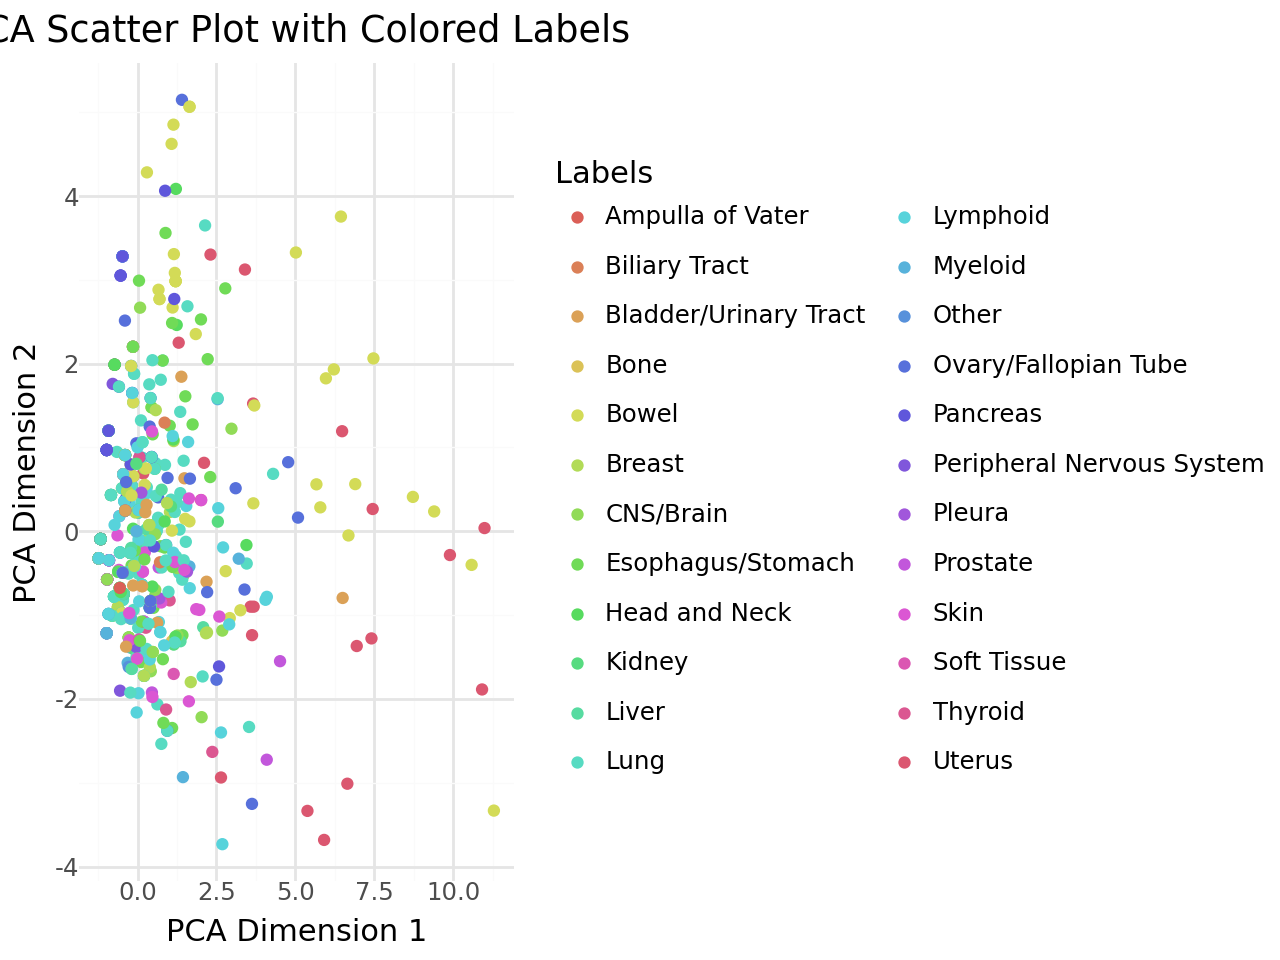

In [18]:
flexynesis.plot_dim_reduced(df, labels, color_type = 'categorical', method='pca')

In [19]:
train_dataset.ann.keys()

dict_keys(['Crizotinib', 'Dovitinib', 'Erlotinib', 'Irinotecan', 'L-685458', 'Lapatinib', 'LBW242', 'Nilotinib', 'Nutlin-3', 'Nvp-aew541', 'Nvp-tae 684', 'Paclitaxel', 'Palbociclib', 'Panobinostat', 'PD-0325901', 'Pha-665752', 'PLX4720', 'Raf265(chir-265)', 'Saracatinib', 'Selumetinib', 'Sorafenib', 'Tanespimycin', 'Topotecan', 'Vandetanib', 'tissueid'])

In [20]:
# List available clinical variables in the training dataset (from .ann)
clinical_vars = ['Erlotinib', 'Crizotinib', 'Paclitaxel', 'Tanespimycin']

# Prepare the data matrices for CNV, RNA, and MUT
ds = train_dataset
df_cnv = pd.DataFrame(ds.dat["cnv"], index=ds.samples, columns=ds.features["cnv"])
df_mut = pd.DataFrame(ds.dat["mutation"], index=ds.samples, columns=ds.features["mutation"])
df_rna = pd.DataFrame(ds.dat["rna"], index=ds.samples, columns=ds.features["rna"])

def get_labels(variable):
    """
    For a given clinical variable, returns a tuple:
      (labels, color_type)
    If a mapping exists, labels are mapped (categorical);
    otherwise, raw values are returned (numerical).
    """
    vals = ds.ann[variable].numpy()
    if variable in ds.label_mappings:
        labels = [ds.label_mappings[variable][int(x.item())] if not math.isnan(x.item()) else "NaN" 
                  for x in ds.ann[variable]]
        color_type = "categorical"
    else:
        labels = vals  # Use raw numeric values
        color_type = "numerical"
    return labels, color_type

PCA plot for CNV data colored by: Erlotinib


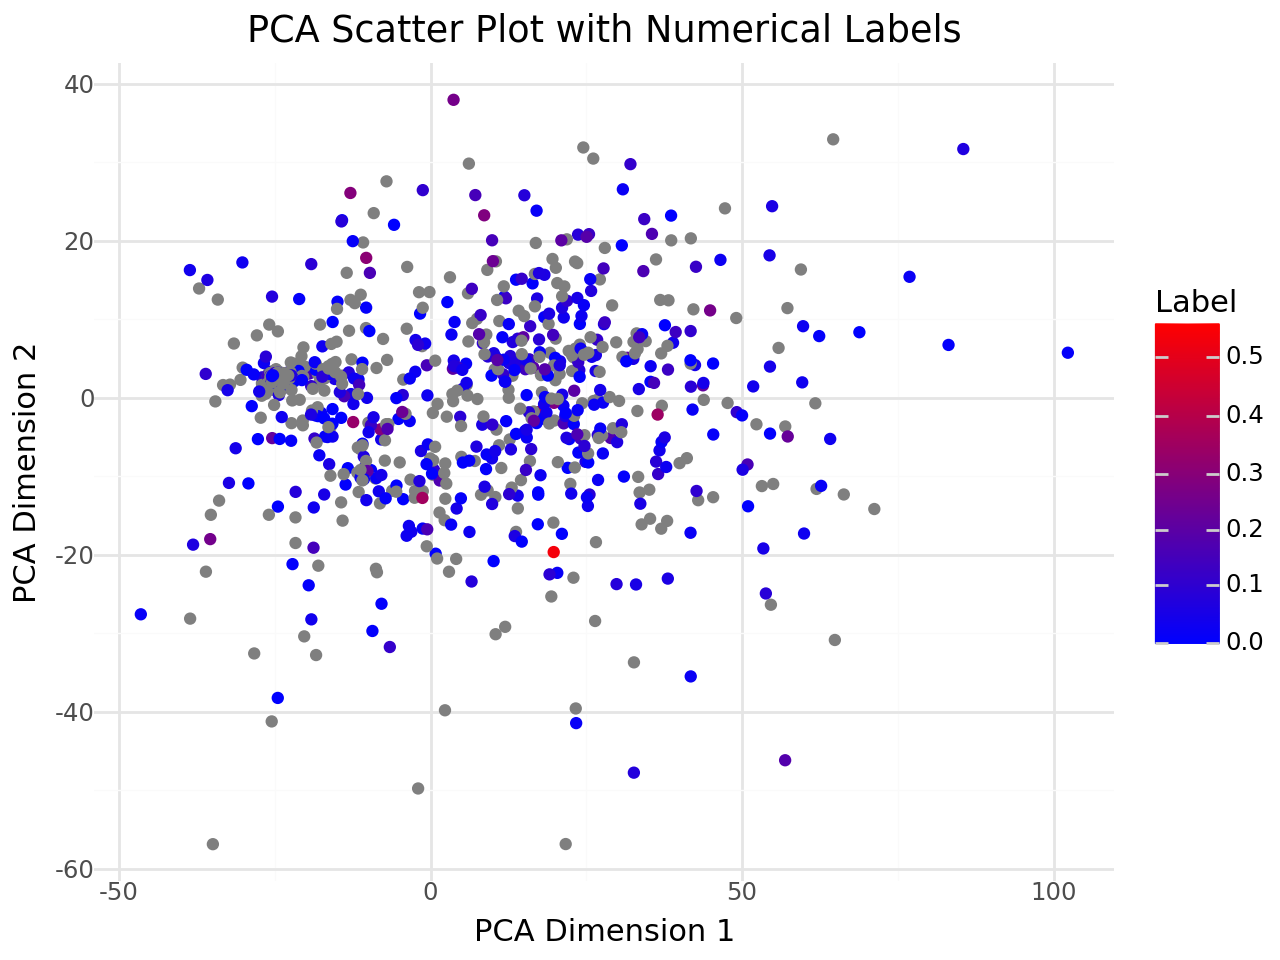

PCA plot for MUT data colored by: Erlotinib


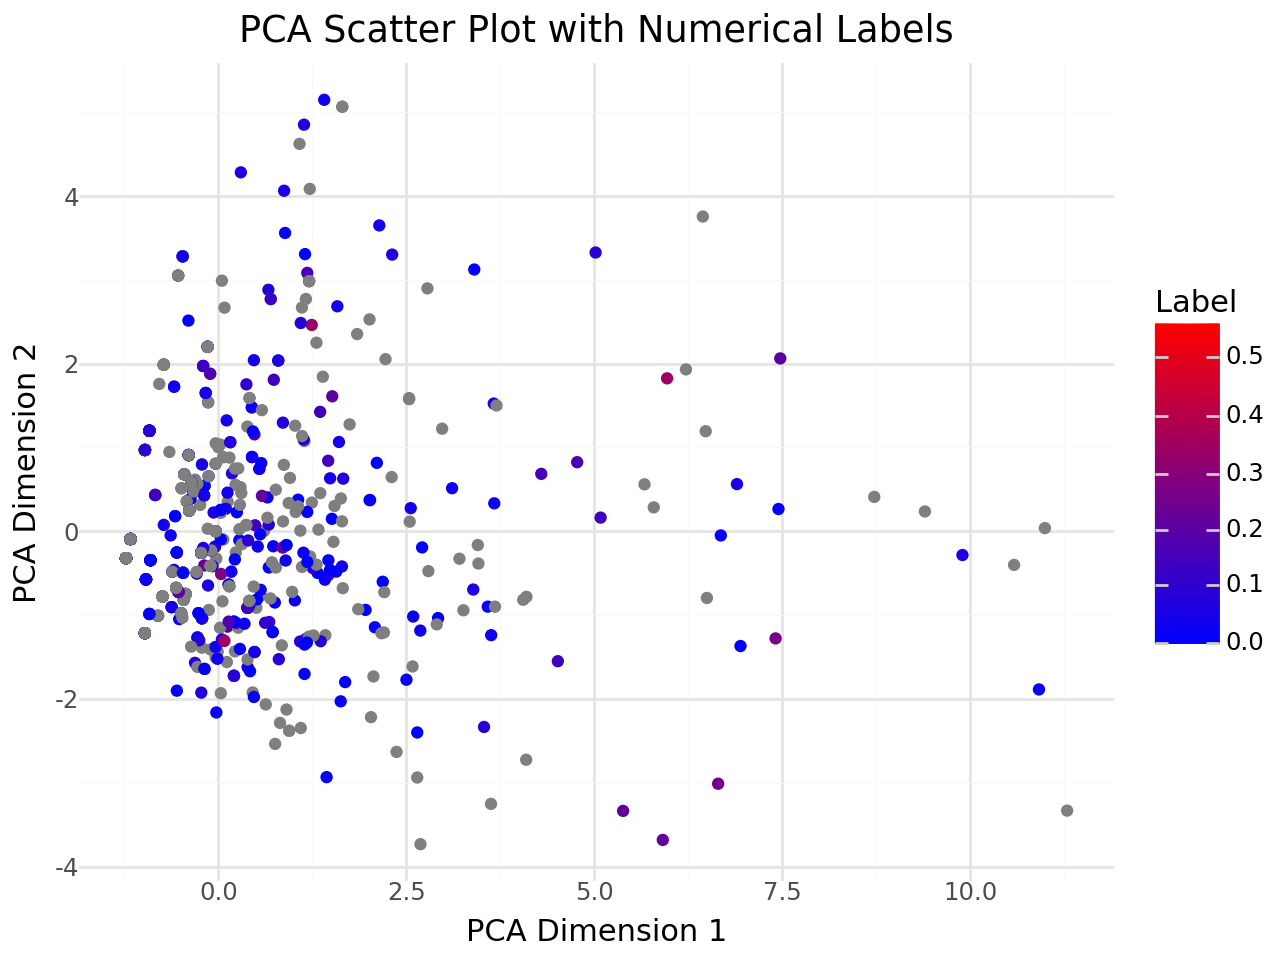

PCA plot for RNA data colored by: Erlotinib


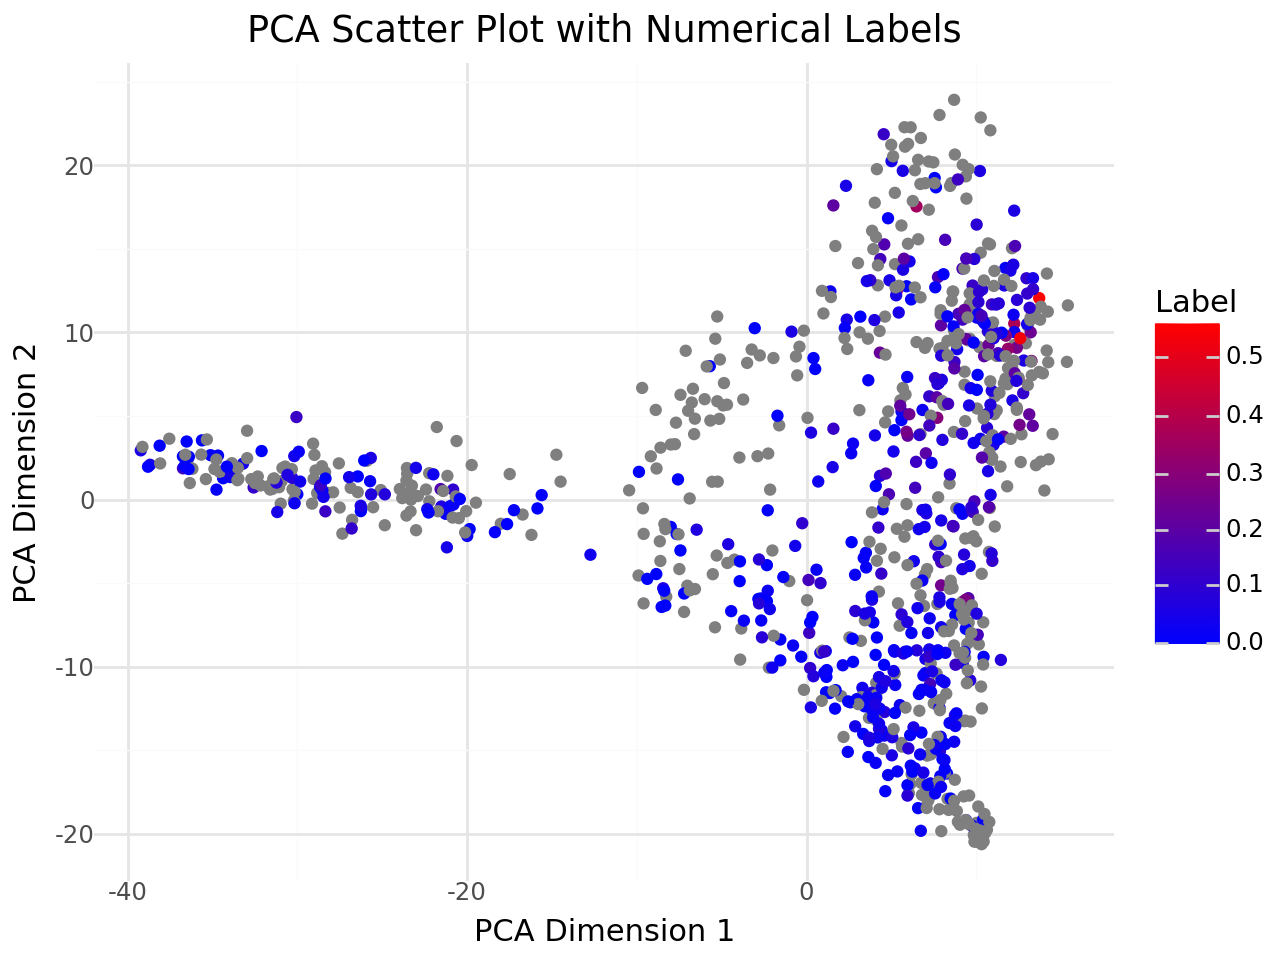

PCA plot for CNV data colored by: Crizotinib


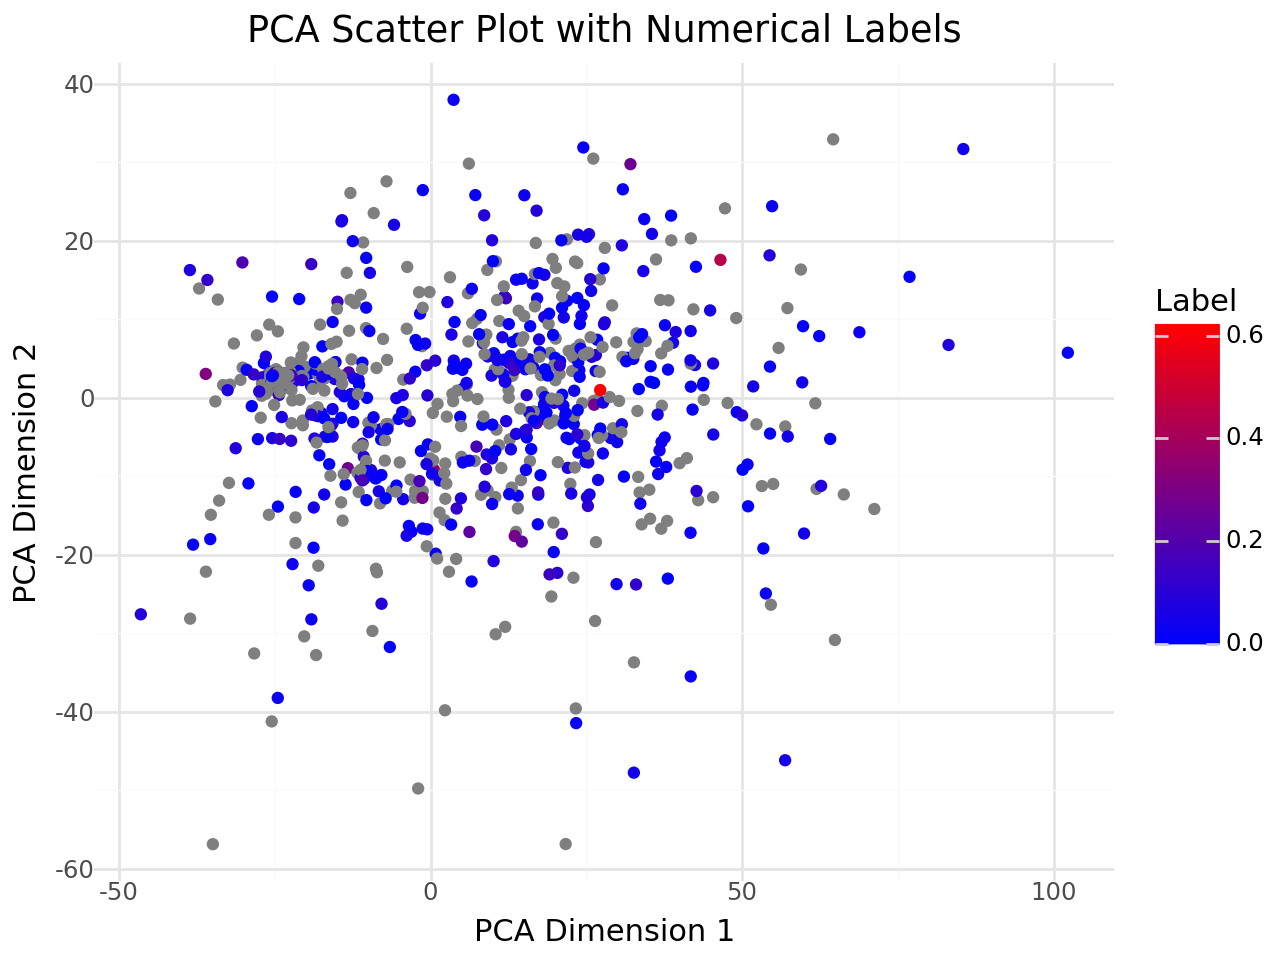

PCA plot for MUT data colored by: Crizotinib


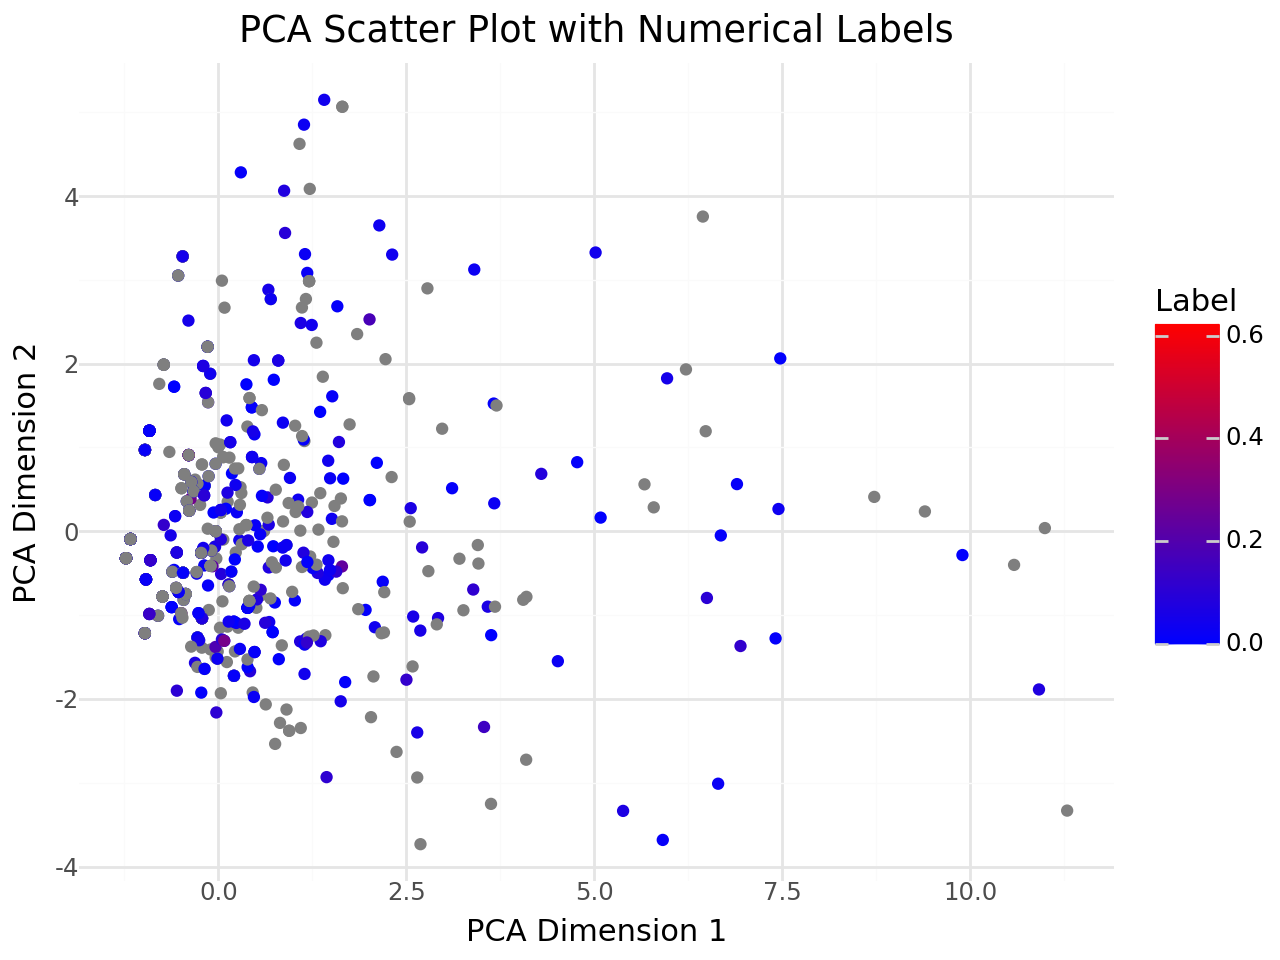

PCA plot for RNA data colored by: Crizotinib


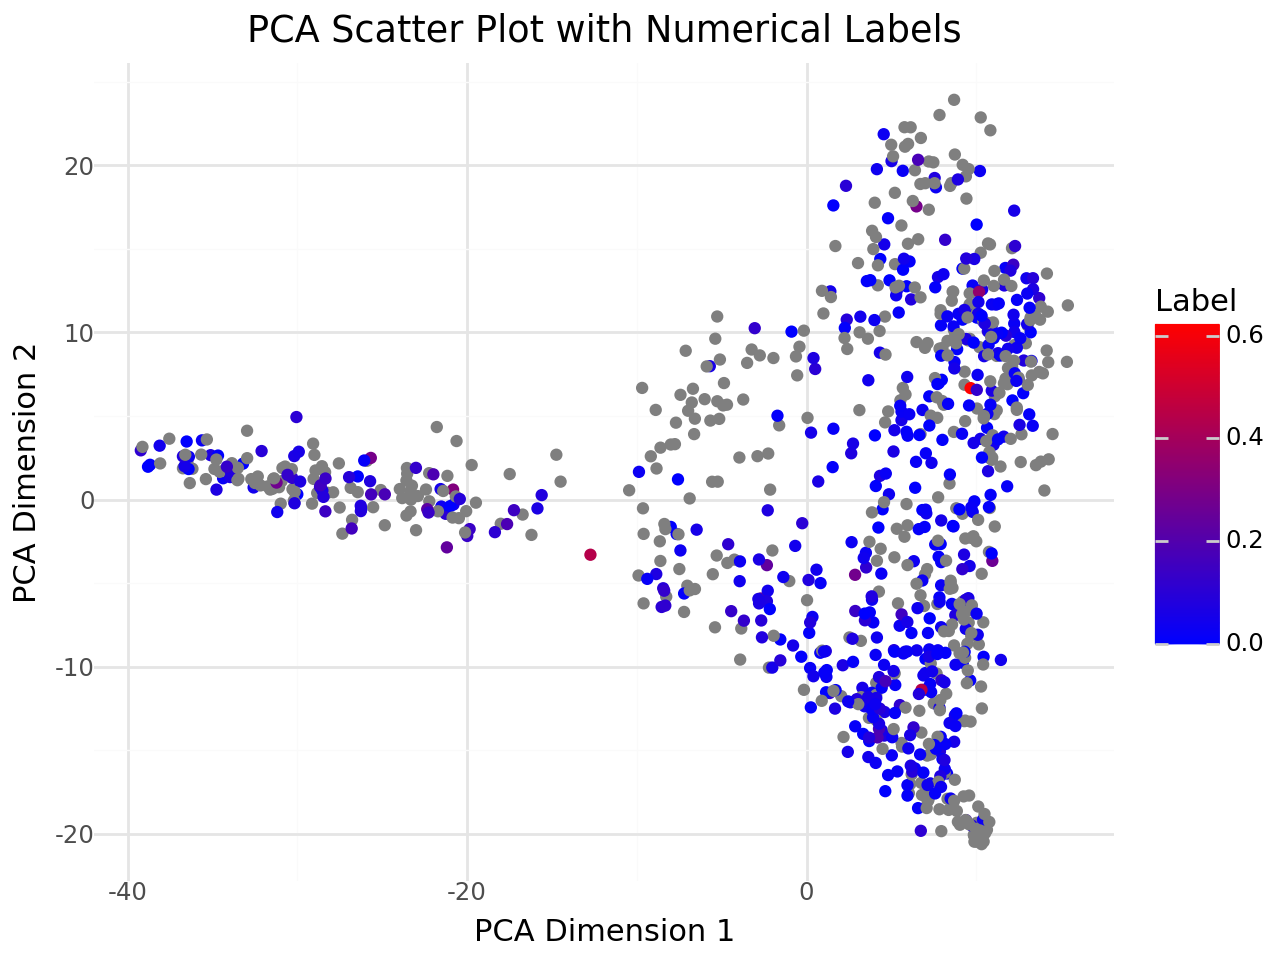

PCA plot for CNV data colored by: Paclitaxel


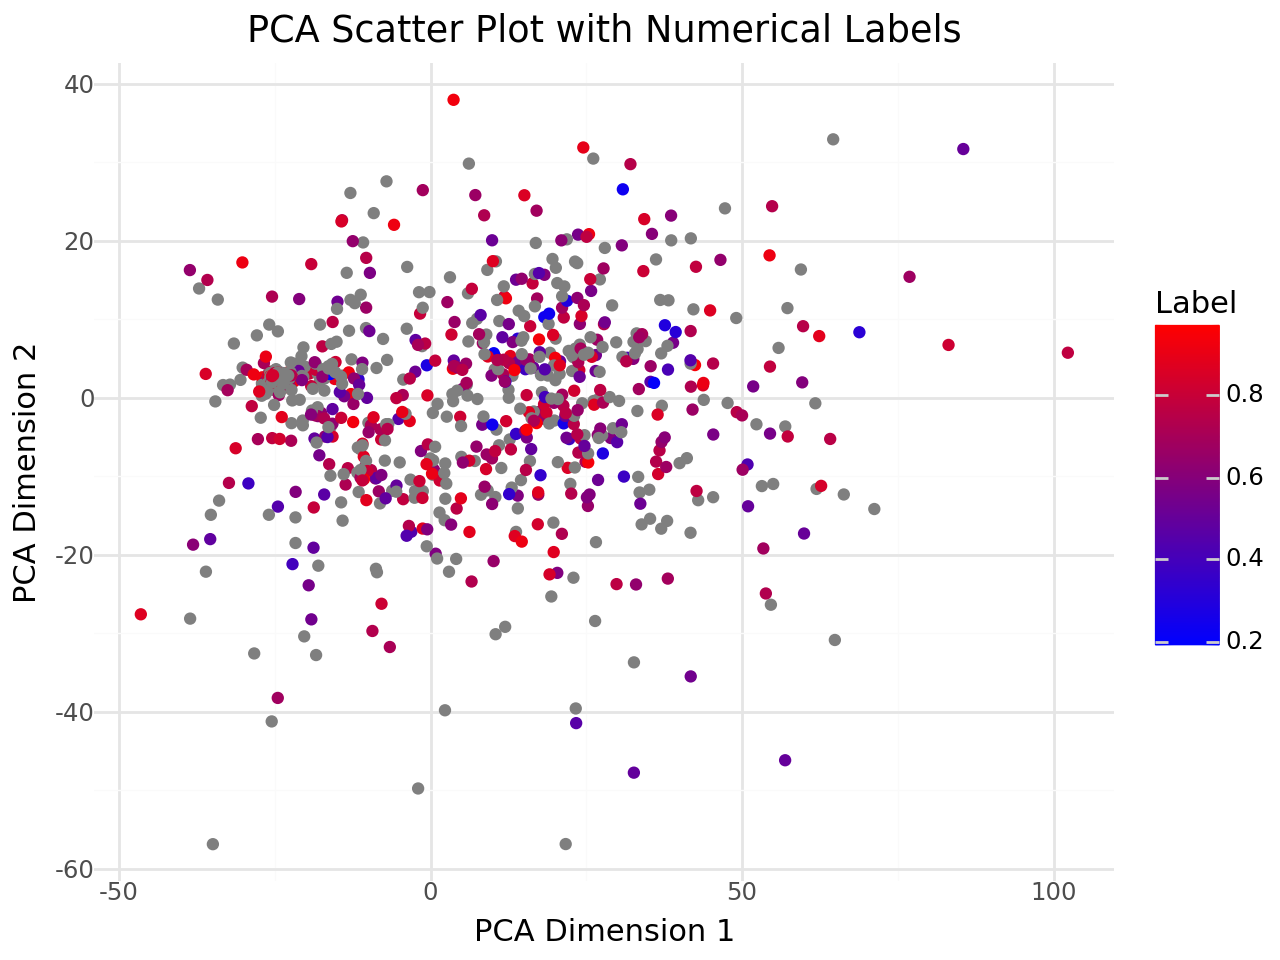

PCA plot for MUT data colored by: Paclitaxel


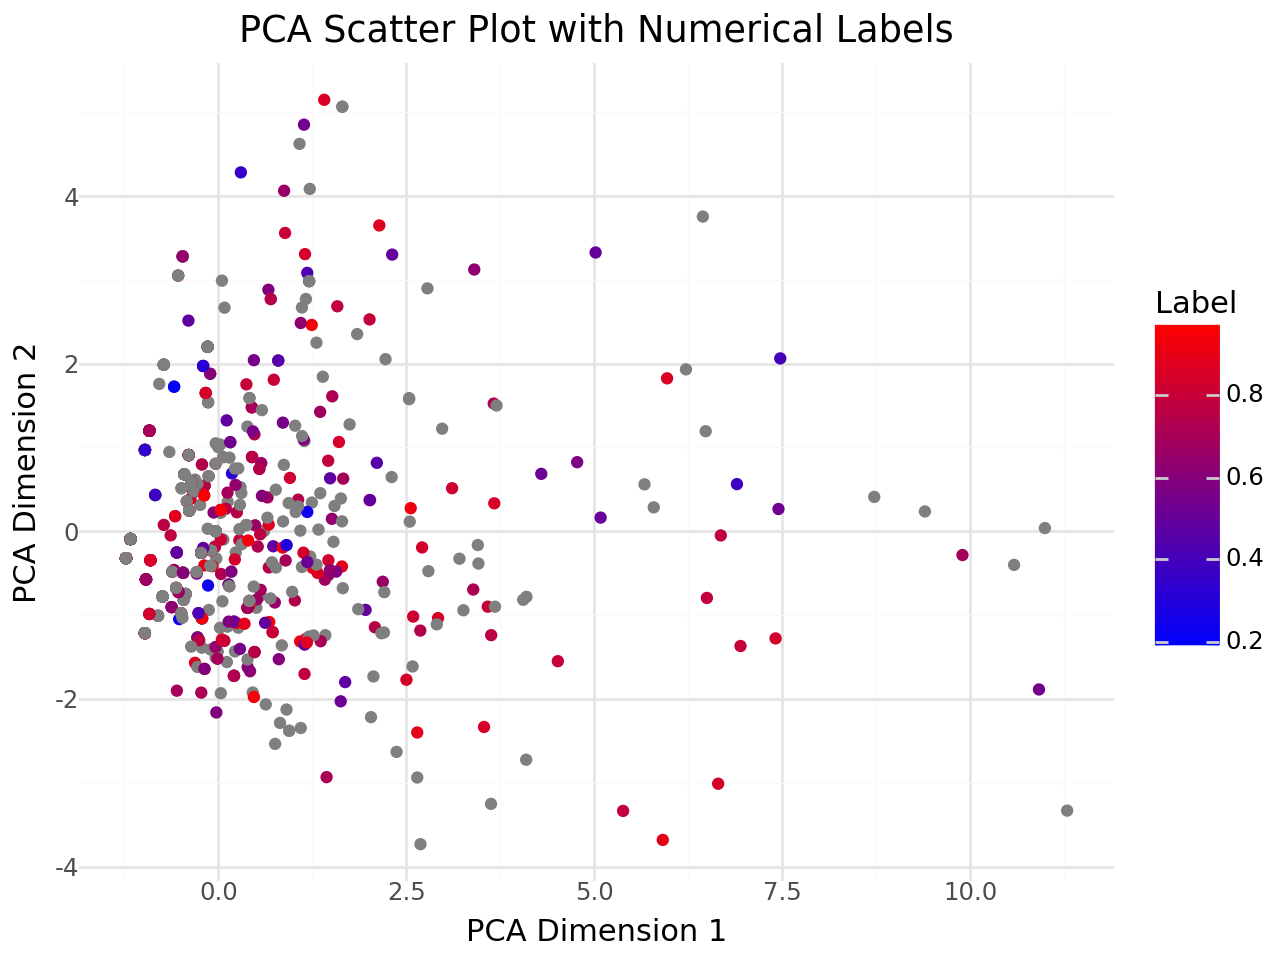

PCA plot for RNA data colored by: Paclitaxel


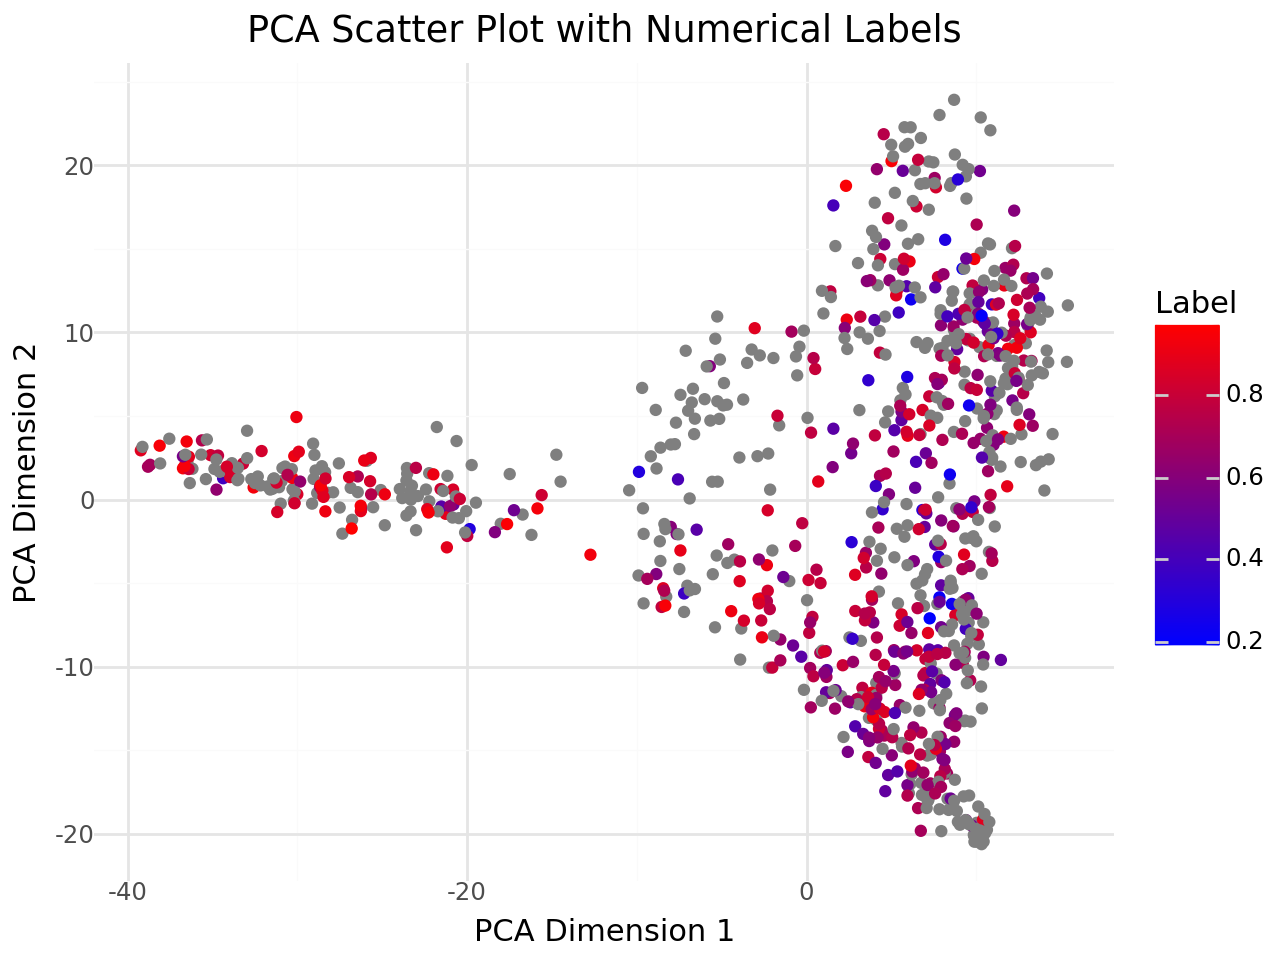

PCA plot for CNV data colored by: Tanespimycin


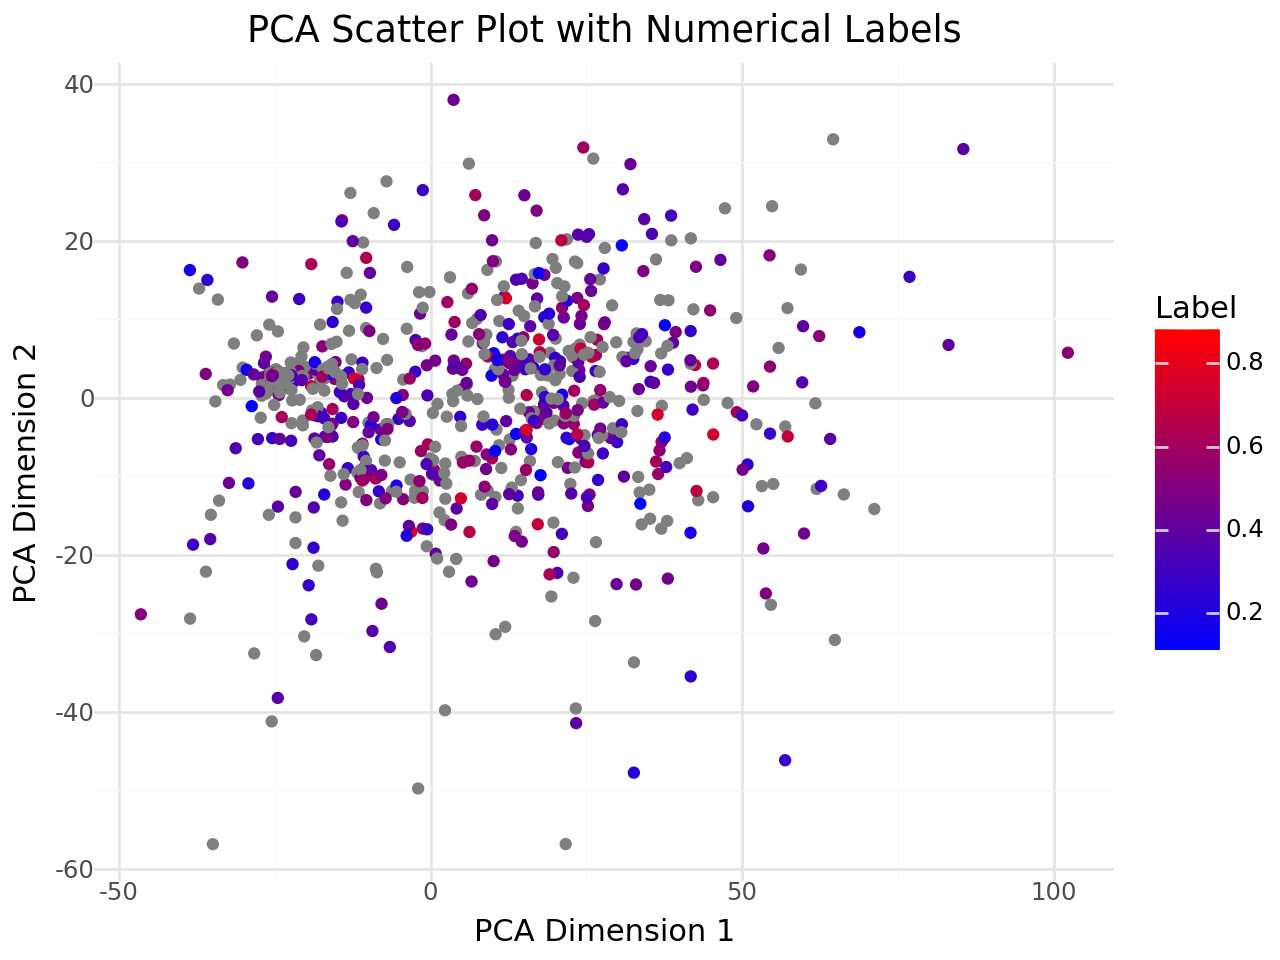

PCA plot for MUT data colored by: Tanespimycin


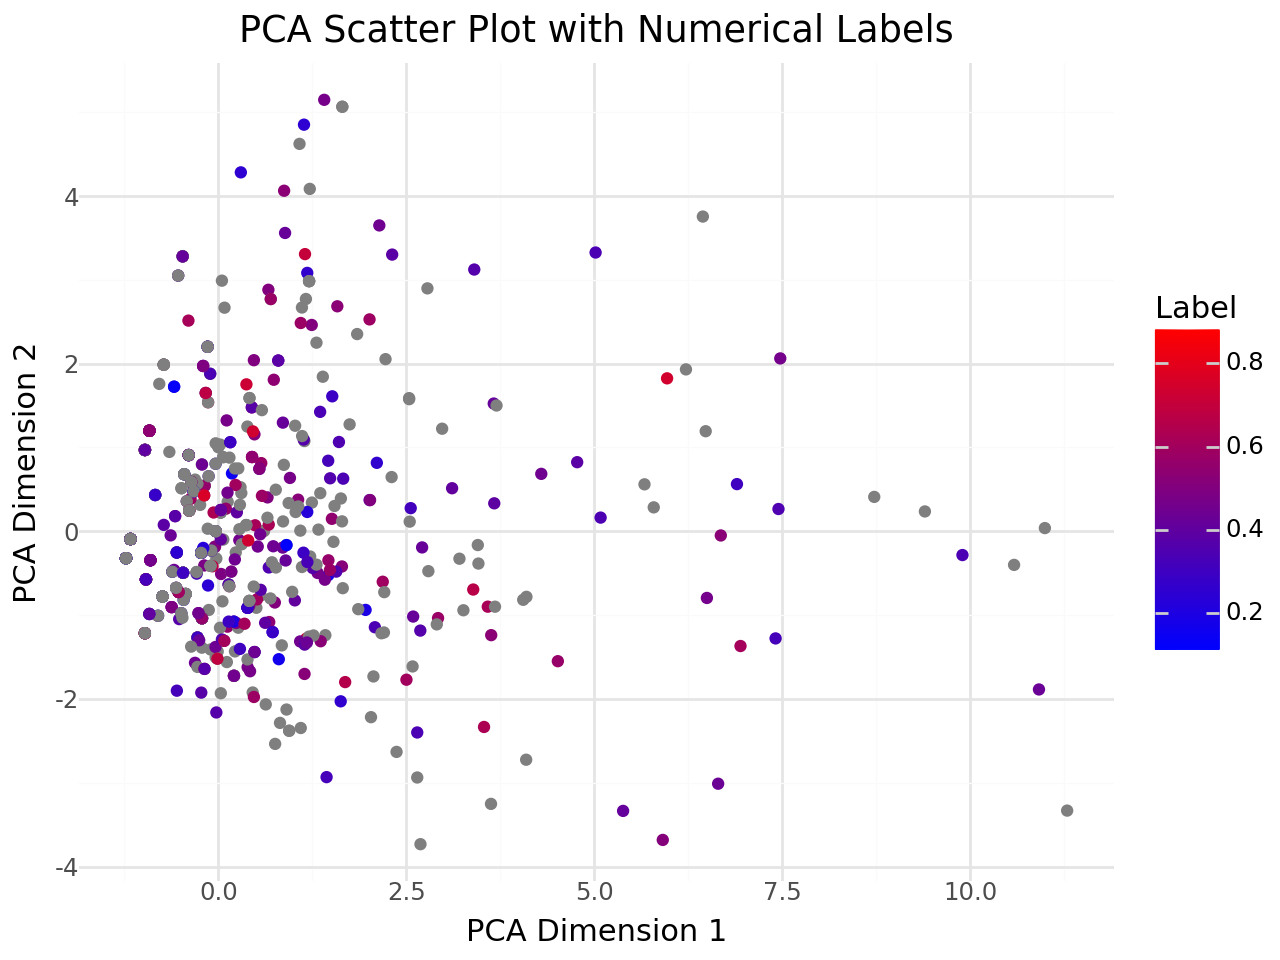

PCA plot for RNA data colored by: Tanespimycin


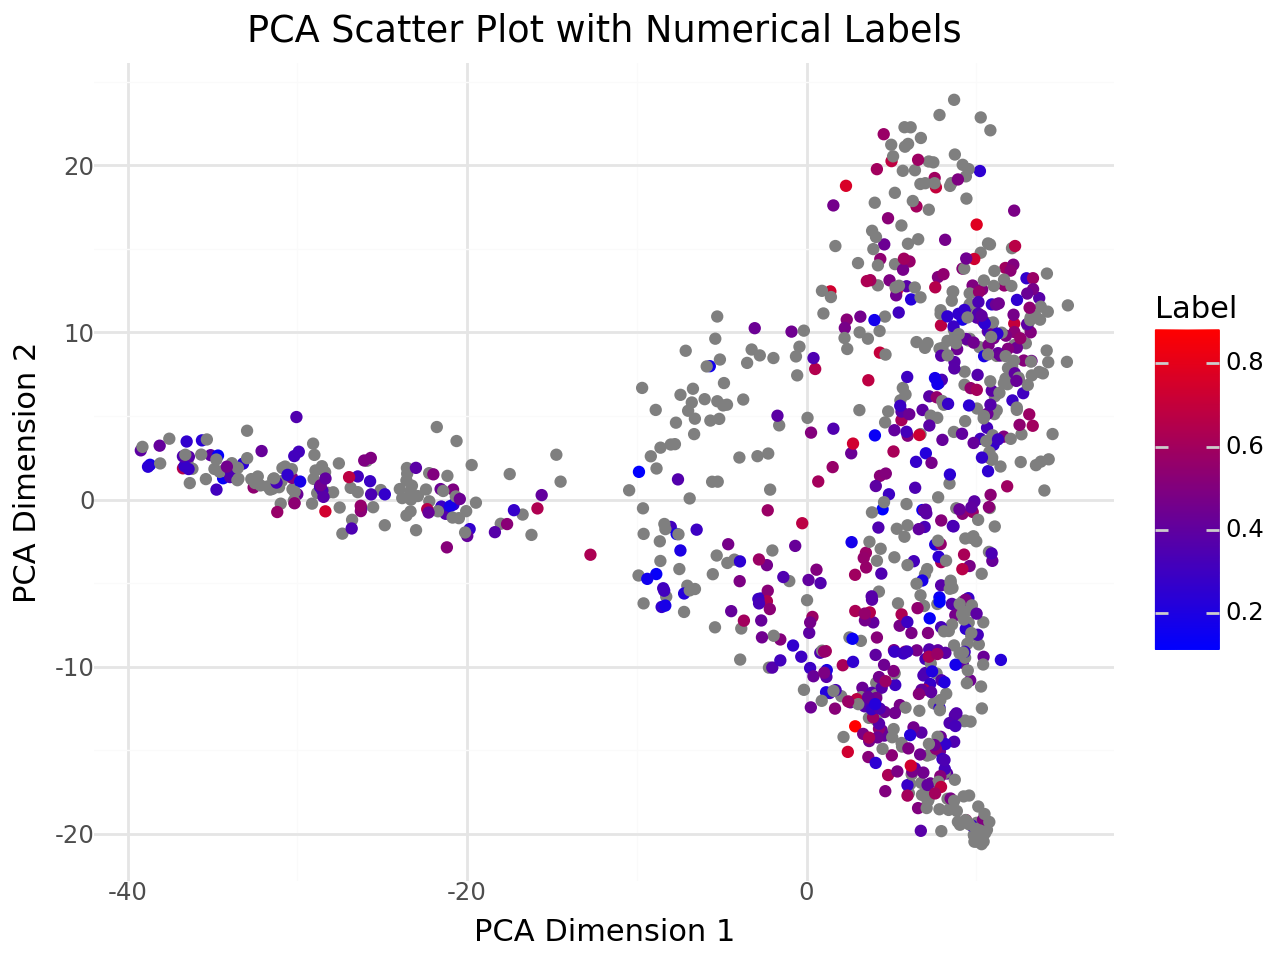

In [21]:
# Loop over each clinical variable and generate PCA plots for both CNA and MUT data
for var in clinical_vars:
    labels, color_type = get_labels(var)
    
    # Plot PCA for CNV data
    print(f"PCA plot for CNV data colored by: {var}")
    fig1 = plot_dim_reduced(df_cnv, labels=labels, color_type=color_type, method="pca")
    # If fig is returned, display it:
    if fig1 is not None:
        fig1.show()
    else:
        plt1.show()
    
    # Plot PCA for MUT data
    print(f"PCA plot for MUT data colored by: {var}")
    fig2 = plot_dim_reduced(df_mut, labels=labels, color_type=color_type, method="pca")
    # If fig is returned, display it:
    if fig2 is not None:
        fig2.show()
    else:
        plt2.show()

    # Plot PCA for RNA data
    print(f"PCA plot for RNA data colored by: {var}")
    fig3 = plot_dim_reduced(df_rna, labels=labels, color_type=color_type, method="pca")
    # If fig is returned, display it:
    if fig3 is not None:
        fig3.show()
    else:
        plt3.show()

# Generate all models
#### Total: 24 (non-GNN) + 12 (GNN) = 36
##### Different data modality combinations
DATA_TYPE_LIST=("mutation" "rna" "cnv" "mutation,cnv" "mutation,rna" "rna,cnv")

##### Two fusion types for non-GNN models
FUSION_MODES=("early" "intermediate")

##### Non-GNN model classes
NON_GNN_CLASSES=("DirectPred" "supervised_vae")

##### GNN model class and convolution types
GNN_CLASS="GNN";
GNN_CONV_TYPES=("GC" "SAGE")

In [22]:
!bash check_multiomics_ccle_vs_gdsc_eval.sh

Running Flexynesis for Erlotinib (CCLE vs GDSC) with skipping if present
Data path:         /home/thesamurai/sciebo/Project_Allocation/module3_trial_multiomics/compgen_course_2025_module3_my_session/submissions/day3/ccle_vs_gdsc/
Target variable:   Erlotinib
HPO iterations:    15
Threads:           12
Num workers:       6
-----------------------------------------------------------
Model: DirectPred | Data: mutation | Fusion: early
Prefix: run_DirectPred_mutation_early
-----------------------------------------------------------
Checking if all required files exist for run_DirectPred_mutation_early ...
All output files found for run_DirectPred_mutation_early. Skipping.
-----------------------------------------------------------
-----------------------------------------------------------
Model: DirectPred | Data: mutation | Fusion: intermediate
Prefix: run_DirectPred_mutation_intermediate
-----------------------------------------------------------
Checking if all required files exist for 

#### a) Import the results of the experiments from step 3, and rank the experiments based on performance (pearson_corr) Which combination yields the best results?

Ranking of experiments by Pearson correlation (descending):


,Prefix,FilePath,PearsonCorr
0,run_DirectPred_rna_intermediate,logs_flexynesis/run_DirectPred_rna_intermediat...,0.453254
1,run_DirectPred_rna_early,logs_flexynesis/run_DirectPred_rna_early/run_D...,0.450047
2,"run_DirectPred_rna,cnv_intermediate","logs_flexynesis/run_DirectPred_rna,cnv_interme...",0.424879
3,run_supervised_vae_rna_early,logs_flexynesis/run_supervised_vae_rna_early/r...,0.422488
4,"run_supervised_vae_mutation,rna_early","logs_flexynesis/run_supervised_vae_mutation,rn...",0.418550
5,run_supervised_vae_rna_intermediate,logs_flexynesis/run_supervised_vae_rna_interme...,0.408476
6,"run_GNN_mutation,rna_SAGE","logs_flexynesis/run_GNN_mutation,rna_SAGE/run_...",0.405497
7,"run_GNN_mutation,rna_GC","logs_flexynesis/run_GNN_mutation,rna_GC/run_GN...",0.402277
8,run_GNN_rna_SAGE,logs_flexynesis/run_GNN_rna_SAGE/run_GNN_rna_S...,0.369327
9,"run_DirectPred_mutation,rna_intermediate","logs_flexynesis/run_DirectPred_mutation,rna_in...",0.350828


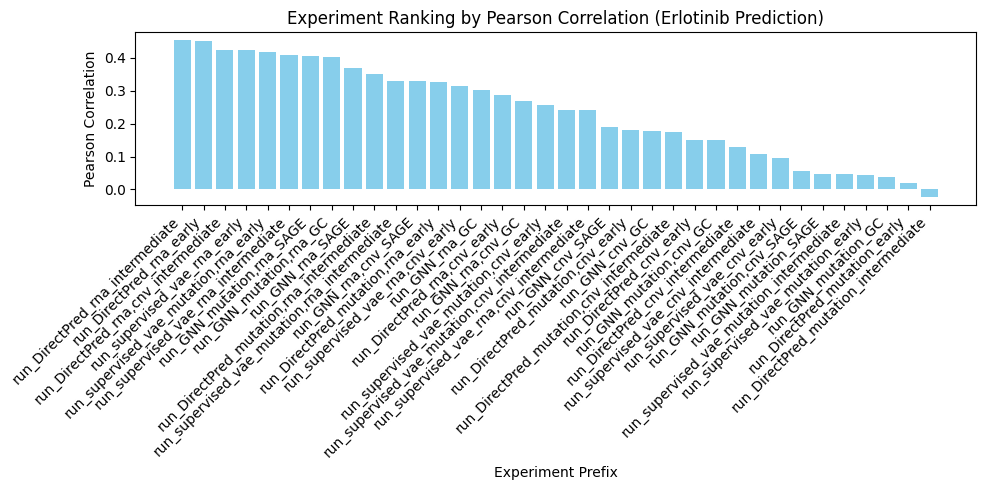

The best model prefix is: run_DirectPred_rna_intermediate


In [23]:
# Directory where logs and results are stored
LOGS_DIR = "logs_flexynesis"

# 1. Gather all .stats.csv files in LOGS_DIR
stats_files = glob.glob(os.path.join(LOGS_DIR, "**", "*.stats.csv"), recursive=True)

results = []
for file_path in stats_files:
    # Derive prefix from the filename (assuming e.g. "run_DirectPred_mut_early.stats.csv")
    prefix = os.path.basename(file_path).replace(".stats.csv", "")

    df_stats = pd.read_csv(file_path)

    # 2. Locate the row with metric == "pearson_corr"
    df_pearson = df_stats[df_stats["metric"] == "pearson_corr"]

    if not df_pearson.empty:
        pearson_val = df_pearson["value"].iloc[0]
    else:
        pearson_val = None  # if it doesn't exist

    results.append({
        "Prefix": prefix,
        "FilePath": file_path,
        "PearsonCorr": pearson_val
    })

# Convert to a DataFrame
results_df = pd.DataFrame(results)

# Drop rows with no pearson_corr available (if any)
results_df.dropna(subset=["PearsonCorr"], inplace=True)

# Sort experiments by pearson_corr descending (best at top)
results_df.sort_values(by="PearsonCorr", ascending=False, inplace=True)
results_df.reset_index(drop=True, inplace=True)

print("Ranking of experiments by Pearson correlation (descending):")
display(results_df)

# Visualize the Pearson correlation across experiments in a simple bar chart
plt.figure(figsize=(10, 5))
plt.bar(results_df["Prefix"], results_df["PearsonCorr"], color="skyblue")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Experiment Prefix")
plt.ylabel("Pearson Correlation")
plt.title("Experiment Ranking by Pearson Correlation (Erlotinib Prediction)")
plt.tight_layout()
plt.show()

# Identify the best model (highest PearsonCorr)
best_model_prefix = results_df.iloc[0]["Prefix"]
print(f"The best model prefix is: {best_model_prefix}")

#### b) Explore the train/test embeddings from the best model (from 4a).

Train Embeddings Shape: (1034, 17)
Test Embeddings Shape: (727, 17)


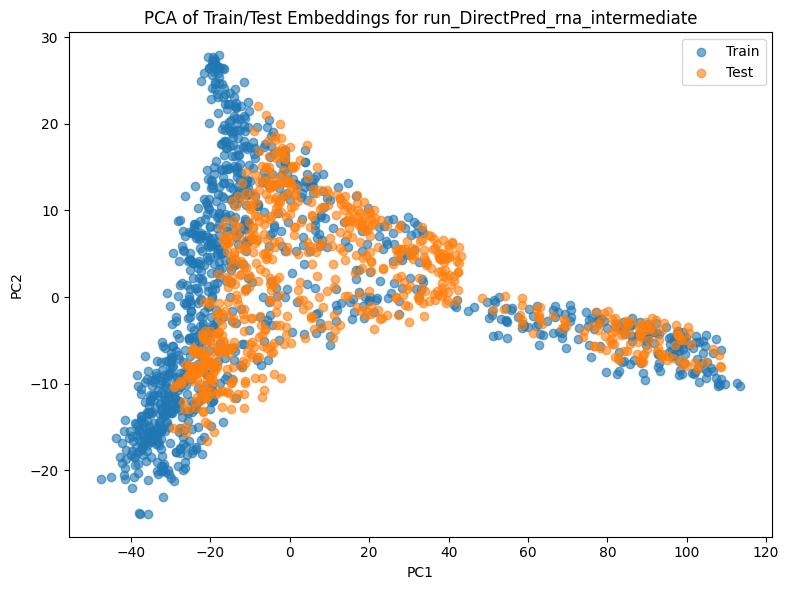

Sample Train Embeddings:


,sample_id,E0,E1,E2,E3,E4,E5,E6,E7,E8,E9,E10,E11,E12,E13,E14,E15
0,CAS-1,-9.521608,3.208619,-6.779980,8.682497,0.630838,-5.129259,6.183675,5.283893,7.447153,0.351322,-3.057861,3.125699,-0.909936,0.227645,-1.655681,6.230409
1,AU565,-3.748832,-3.107173,2.502489,-7.949045,0.658635,3.967231,3.281655,-10.204082,-5.764284,3.977929,3.184104,-6.071881,-5.214666,-3.921545,-9.308682,-7.426257
2,HARA [Human squamous cell lung carcinoma],-3.183113,-2.197794,-0.365624,-2.435834,1.628433,0.856045,1.761127,-6.362205,-4.699937,2.035301,1.716697,-3.473259,-1.756452,-2.806872,-6.088756,-2.427325
3,MJ,24.992676,12.755637,-0.364261,-10.412441,1.358003,30.916039,-15.354524,39.934517,27.702824,-19.248700,-11.853328,20.857853,-9.819810,-12.947104,39.731792,-1.857072
4,SU-DHL-4,37.493378,17.792190,4.345458,-14.346065,0.566390,46.487186,-23.227781,58.748634,39.902863,-25.985107,-17.158508,31.435516,-15.838624,-22.946583,58.213455,-3.906227


Sample Test Embeddings:


,sample_id,E0,E1,E2,E3,E4,E5,E6,E7,E8,E9,E10,E11,E12,E13,E14,E15
0,CAS-1,-2.699492,4.467287,-4.155583,4.622183,-0.218824,-1.142177,0.671159,7.706150,7.442161,-2.828698,-5.851207,4.185926,1.133991,1.294857,5.546989,5.151996
1,DJM-1,-4.247461,-3.437389,-0.124484,-3.895321,2.442992,1.929470,2.074376,-8.366708,-6.465372,2.538626,2.780972,-4.879032,-2.930313,-4.891748,-8.043406,-4.690967
2,MN-60,35.054073,17.645554,3.266762,-13.409164,0.220840,42.818493,-22.172955,54.141330,37.560450,-25.136063,-17.731808,28.402302,-13.938953,-19.344212,55.423870,-2.933608
3,Rh1,12.148687,8.613775,0.155137,-5.376956,-0.524279,12.207080,-8.110361,18.078316,13.644163,-9.120977,-9.361376,10.781049,-0.559511,0.215428,19.912495,3.044901
4,MJ,25.870636,13.899988,-0.703533,-10.501465,1.698678,31.867535,-16.658726,41.132430,28.505611,-20.360613,-13.033720,21.268270,-9.719605,-13.225058,41.705616,-1.629420


In [24]:
BEST_MODEL_DIR = os.path.join(LOGS_DIR, best_model_prefix)

# Embedding files look like: "<prefix>.embeddings_train.csv" and "<prefix>.embeddings_test.csv"
train_embeddings_path = os.path.join(BEST_MODEL_DIR, f"{best_model_prefix}.embeddings_train.csv")
test_embeddings_path  = os.path.join(BEST_MODEL_DIR, f"{best_model_prefix}.embeddings_test.csv")

# 1) Read and rename columns so the first column = "sample_id"
df_train_embed = pd.read_csv(train_embeddings_path)
df_test_embed = pd.read_csv(test_embeddings_path)

# Rename the first column in each to "sample_id" (since it's originally the sample name)
df_train_embed.rename(columns={df_train_embed.columns[0]: "sample_id"}, inplace=True)
df_test_embed.rename(columns={df_test_embed.columns[0]: "sample_id"}, inplace=True)

print("Train Embeddings Shape:", df_train_embed.shape)
print("Test Embeddings Shape:", df_test_embed.shape)

# 2) Identify the embedding columns ("E0", "E1", ..., "E17"). 
#    We assume all columns except the first one are the embedding features.
embedding_cols = df_train_embed.columns[1:]  # E0..E17 for train

# 3) Run PCA on the numeric embedding columns only
pca = PCA(n_components=2)

# Fit on train, transform train and test
train_pca = pca.fit_transform(df_train_embed[embedding_cols])
test_pca  = pca.transform(df_test_embed[embedding_cols])

# 4) Plot the train/test embeddings in PCA space
plt.figure(figsize=(8, 6))
plt.scatter(train_pca[:,0], train_pca[:,1], alpha=0.6, label="Train")
plt.scatter(test_pca[:,0], test_pca[:,1], alpha=0.6, label="Test")
plt.title(f"PCA of Train/Test Embeddings for {best_model_prefix}")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.tight_layout()
plt.show()

# 5) Display a small sample of each embedding DataFrame
print("Sample Train Embeddings:")
display(df_train_embed.head())

print("Sample Test Embeddings:")
display(df_test_embed.head())

#### c) Import the feature importance scores from the best model (from 4a). Get top 10 markers.

In [25]:
feature_importance_path = os.path.join(BEST_MODEL_DIR, f"{best_model_prefix}.feature_importance.IntegratedGradients.csv")

# 1. Read the feature importance CSV
df_importance = pd.read_csv(feature_importance_path)

# Columns: target_variable, target_class, target_class_label, layer, name, importance, explainer
# 2. Sort by highest 'importance'
df_importance.sort_values(by="importance", ascending=False, inplace=True)

# 3. Extract the top 10 markers
top10 = df_importance.head(10)

print(f"Top 10 markers from {best_model_prefix}:")
display(top10)

# 4. Provide placeholders for further analysis
print("Next step: check if these markers (in 'name' column) are known to be related to Erlotinib response.")

Top 10 markers from run_DirectPred_rna_intermediate:


,target_variable,target_class,target_class_label,layer,name,importance,explainer
847,Erlotinib,0,NaN,rna,HKDC1,0.001761,IntegratedGradients
118,Erlotinib,0,NaN,rna,EGFR,0.001344,IntegratedGradients
1116,Erlotinib,0,NaN,rna,XDH,0.001312,IntegratedGradients
612,Erlotinib,0,NaN,rna,CTSV,0.001202,IntegratedGradients
1008,Erlotinib,0,NaN,rna,GLS2,0.001201,IntegratedGradients
528,Erlotinib,0,NaN,rna,ACSL5,0.001139,IntegratedGradients
1224,Erlotinib,0,NaN,rna,VILL,0.001129,IntegratedGradients
435,Erlotinib,0,NaN,rna,ICA1,0.001120,IntegratedGradients
572,Erlotinib,0,NaN,rna,SH3YL1,0.001118,IntegratedGradients
707,Erlotinib,0,NaN,rna,TBC1D30,0.001102,IntegratedGradients


Next step: check if these markers (in 'name' column) are known to be related to Erlotinib response.


#### Do literature search. Are any of the top markers associated to “Erlotinib”?

Here is a summary of the associations between each gene from the provided table and Erlotinib treatment in the context of cancer therapies, supported by relevant research references:

1. HKDC1: Research indicates that HKDC1 (Hexokinase Domain Containing 1) plays a significant role in the metabolic processes of cancer cells, particularly in gastric cancer. The silencing of HKDC1 has been shown to inhibit the proliferation and glycolysis of gastric cancer cells, potentially enhancing the effectiveness of Erlotinib as a treatment. This suggests that targeting HKDC1 may complement the therapeutic impacts of Erlotinib in metabolic regulation Chen et al. (2023).

2. EGFR: The epidermal growth factor receptor (EGFR) is the primary target of Erlotinib. Erlotinib's efficacy is heavily reliant on its ability to inhibit EGFR signaling pathways, which are crucial in promoting cell growth and survival in non-small cell lung cancer (NSCLC). Studies have demonstrated that the presence of specific EGFR mutations can predict response to Erlotinib treatment, reinforcing its standing as a foundational therapy for cancers harboring these mutations (Abourbeh et al., 2015; Sette et al., 2015).

3. XDH: Xanthine dehydrogenase (XDH) has been implicated in various metabolic processes, yet its association with Erlotinib treatment is not well-established. Some studies suggest metabolic alterations in cancer cells can impact drug resistance, but the evidence directly linking XDH expression or activity to Erlotinib effectiveness is minimal. Further research is needed to clarify this relationship (Shen et al., 2019).

4. CTSV: Cathepsin V (CTSV) has not been directly associated with Erlotinib treatment in the current cancer literature. However, cathepsins are involved in cancer progression and may influence tumor microenvironments, which could be relevant in targeted therapies like Erlotinib. Without specific studies connecting CTSV to Erlotinib, its role remains speculative (Shen et al., 2019).

5. GLS2: Glutaminase 2 (GLS2) is involved in glutamine metabolism, which cancer cells often exploit. While a study demonstrated that GLS1 inhibitors can enhance the sensitivity of NSCLC cells to Erlotinib, direct studies on GLS2 specifically in the context of Erlotinib are limited (Wu et al., 2017).

6. ACSL5: Acyl-CoA synthetase long-chain family member 5 (ACSL5) has been reported to play a role in fatty acid metabolism and has implications in cancer biology. However, the influence of ACSL5 on Erlotinib resistance has not been extensively explored in the literature, indicating a need for further investigation into its potential interactions with Erlotinib therapy (Shen et al., 2019).

7. VILL: Villin (VILL) is a protein linked to cytoskeletal dynamics in epithelial cells. While its exact role in Erlotinib sensitivity is not well-documented, proteins that modulate cell architecture may influence drug responses indirectly. However, specific evidence linking VILL to Erlotinib treatment is lacking (Shen et al., 2019).

8. ICA1: ICA1 (Inducible cAMP early repressor) has not been studied directly in connection with Erlotinib. Its involvement in intracellular signaling could hypothetically affect how cancer cells respond to various treatments, including Erlotinib, but further research is required to establish any direct correlations (Shen et al., 2019).

9. SH3YL1: The relationship of SH3YL1 to Erlotinib or cancer treatment in general has not been well-characterized in existing literature. As such, it does not appear to be a primary focus in Erlotinib research, indicating a need for more targeted studies to reveal its potential role (Shen et al., 2019).

10. TBC1D30: The gene TBC1D30 does not have established connections with Erlotinib treatment in the available cancer research literature. Its involvement in intracellular processes suggests a possible role in cancer cell communication, but it does not provide direct insights into Erlotinib efficacy (Shen et al., 2019).


References:

1. Abourbeh, G., Itamar, B., Salnikov, O., Beltsov, S., & Mishani, E. (2015). Identifying erlotinib-sensitive non-small cell lung carcinoma tumors in mice using [11c]erlotinib pet. Ejnmmi Research, 5(1). https://doi.org/10.1186/s13550-014-0080-0
2. Chen, Y., Bao, T., Li, J., Lu, J., & Feng, J. (2023). Hkdc1 silencing inhibits proliferation and glycolysis of gastric cancer cells. Journal of Oncology, 2023, 1-15. https://doi.org/10.1155/2023/3876342
3. Sette, G., Salvati, V., Mottolese, M., Visca, P., Gallo, E., Fecchi, K., … & Eramo, A. (2015). Tyr1068-phosphorylated epidermal growth factor receptor (egfr) predicts cancer stem cell targeting by erlotinib in preclinical models of wild-type egfr lung cancer. Cell Death and Disease, 6(8), e1850-e1850. https://doi.org/10.1038/cddis.2015.217
4. Shen, T., Cheng, X., Xia, C., Li, Q., Gao, Y., Pan, D., … & Li, Y. (2019). Erlotinib inhibits colon cancer metastasis through inactivation of trkb‐dependent erk signaling pathway. Journal of Cellular Biochemistry, 120(7), 11248-11255. https://doi.org/10.1002/jcb.28400
5. Wu, C., Zheng, M., Gao, S., Luan, S., Li, C., Wang, L., … & Li, H. (2017). A natural inhibitor of kidney-type glutaminase: a withanolide from physalis pubescens with potent anti-tumor activity. Oncotarget, 8(69), 113516-113530. https://doi.org/10.18632/oncotarget.23058